In [27]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from torchvision import transforms as T, utils

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

from PIL import Image
from tqdm.auto import tqdm
from ema_pytorch import EMA
import numpy as np
import pandas as pd

from accelerate import Accelerator

def exists(x):
    return x is not None

class HPADataset(torch.utils.data.Dataset):
    def __init__(
        self,
        folder,
        image_size,
        exts=["jpg", "jpeg", "png"],
        augment_horizontal_flip=False,
        convert_image_to=None,
    ):
        super().__init__()
        self.folder = folder
        self.image_size = image_size
        self.dataframe = pd.read_csv(folder + "/train.csv")
        maybe_convert_fn = (
            partial(convert_image_to, convert_image_to)
            if exists(convert_image_to)
            else nn.Identity()
        )

        self.transform = T.Compose(
            [
                T.Lambda(maybe_convert_fn),
                T.Resize(image_size),
                T.RandomHorizontalFlip() if augment_horizontal_flip else nn.Identity(),
                T.CenterCrop(image_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]
        )
        self.channels = ['red', 'green', 'blue', 'yellow']

    def get_images(self, id, root_path, channels):
        images = list()
        for channel in channels:
            path = root_path + '/train/{}_{}.png'.format(id, channel)
            image = Image.open(path)
            images.append(image)
        return images

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        id = self.dataframe.iloc[index, 0]
        images = self.get_images(id, self.folder, self.channels)

        size = np.shape(images[0])[0]
        zeros = np.zeros((size, size))

        # Create arrays for each image with 3 channels
        red_array = np.stack((images[0], zeros, zeros), 2)
        green_array = np.stack((zeros, images[1], zeros), 2)
        blue_array = np.stack((zeros, zeros, images[2]), 2)
        # Place yellow across both red and green channels
        yellow_array = np.stack((images[3], images[3], zeros), 2)

        # Convert to image
        red_image = Image.fromarray(np.uint8(red_array))
        green_image = Image.fromarray(np.uint8(green_array))
        blue_image = Image.fromarray(np.uint8(blue_array))
        yellow_image = Image.fromarray(np.uint8(yellow_array))

        # Copy over yellow into red and blue taking the max value of each pixel between the two
        # Red / Yellow
        red_yellow_array = np.maximum(red_array, yellow_array)
        red_yellow_image = Image.fromarray(np.uint8(red_yellow_array))

        # Green / Yellow
        green_yellow_array = np.maximum(green_array, yellow_array)
        green_yellow_image = Image.fromarray(np.uint8(green_yellow_array))

        # Final solution to blend RGBY into RGB
        blended_array = np.stack((
            np.maximum(images[0], images[3]),
            np.maximum(images[1], images[3]),
            images[2]
        ), 2)

        blended_image = Image.fromarray(np.uint8(blended_array))

        return self.transform(blended_image)

In [28]:
folder = "/run/user/1128299809/gvfs/smb-share:server=rds.icr.ac.uk,share=data/DBI/DUDBI/DYNCESYS/mvries/Kaggle/hpa-single-cell-image-classification"
accelerator = Accelerator(
            split_batches=True, mixed_precision="fp16"
        )

def cycle(dl):
    while True:
        for data in dl:
            yield data
            

ds = HPADataset(
            folder=folder,
            image_size=128,
            augment_horizontal_flip=True,
            convert_image_to=None,
        )
dl = DataLoader(
            ds,
            batch_size=1,
            shuffle=True,
            pin_memory=True,
            num_workers=cpu_count(),
        )

dl = accelerator.prepare(dl)
dl = cycle(dl)

In [29]:
for data in dl:
    print(data)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.0665, -2.1008, -2.1008],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0007, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

tensor([[[[-2.0837, -2.1008, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1008, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.4672, -1.4843, -1.4158,  ..., -1.9980, -1.9980, -1.9467],
          [-1.6042, -1.6727, -1.6213,  ..., -1.7754, -1.8097, -1.6555],
          [-1.5699, -1.6555, -1.6042,  ..., -1.7240, -1.6555, -1.6384]],

         [[-2.0007, -2.0182, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0182, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.4580, -1.4755, -1.3704,  ..., -1.9132, -1.9132, -1.8782],
          [-1.5280, -1.6681, -1.6155,  ..., -1.7206, -1.7381, -1.5980],
          [-1.5105, -1.6506, -1.5980,  ..., -1.7031, -1.6506, -1.5980]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

KeyboardInterrupt: 

In [31]:
data.min()

tensor(-2.1179, device='cuda:0')

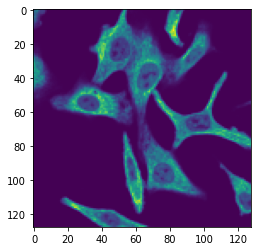

In [32]:
import matplotlib.pyplot as plt

plt.imshow(torch.squeeze(data).detach().cpu().numpy()[0])

In [33]:
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

n_img = normalize_to_neg_one_to_one(torch.squeeze(data).detach().cpu().numpy())

In [37]:
n_img.max()

3.5828323

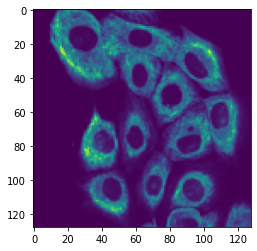

In [25]:
plt.imshow(n_img[0])